In [1]:
import numpy as np
from scipy.signal import convolve2d 
from os import path, getcwd, system, getenv
from astropy.io import fits
from time import perf_counter
import urllib.request
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import glob
import matplotlib.gridspec as gridspec

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import sys,inspect
currentdir = path.dirname(path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = path.dirname(currentdir)
sys.path.append(parentdir)
# from deconv import cube_deconv
# from ppxf_wrap import ppxf_wrap

# import warnings

# if True:
#     print('Set warnings.filterwarnings as "ignore"')
#     print('Warning Message will not be printed')
#     warnings.filterwarnings("ignore")

from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy import constants
import pandas as pd

# import plotly.express as px
from astroquery.mast import Observations


from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
from astropy.nddata.utils import Cutout2D

from astropy.wcs import WCS
import astropy

In [2]:
import astroquery


width_val=u.Quantity(1600, unit='arcsec')
height_val=u.Quantity(1600, unit='arcsec')
from astroquery.skyview import SkyView
SkyView.get_image_list(position='NGC 4631',
                       survey=['DSS'],
                       width=width_val,
                       height=height_val
                      )

['https://skyview.gsfc.nasa.gov/tempspace/fits/skv22210879863087.fits']

In [2]:
def set_rcparams_prop(amp=1, fs=22, tickamp=None):
#     fs=18
    if tickamp==None:
        tickamp=amp
    tickmajorwidth=2.5*amp
    tickminorwidth=2.5*amp
    axeslw=2.5*amp
    tmjs=6*tickamp
    tmns=tmjs/3.5*2
    plt.rcParams['axes.titlesize']=fs
    plt.rcParams['axes.labelsize']=fs
    plt.rcParams['xtick.labelsize']=fs
    plt.rcParams['ytick.labelsize']=fs
    plt.rcParams['axes.linewidth'] = axeslw
    plt.rcParams['xtick.major.width'] = tickmajorwidth
    plt.rcParams['ytick.major.width'] = tickmajorwidth
    plt.rcParams['xtick.minor.width'] = tickminorwidth
    plt.rcParams['ytick.minor.width'] = tickminorwidth
    plt.rcParams['xtick.major.size'] = tmjs
    plt.rcParams['ytick.major.size'] = tmjs
    plt.rcParams['xtick.minor.size'] = tmns
    plt.rcParams['ytick.minor.size'] = tmns

In [3]:

obs_table = Observations.query_region("322.49324 12.16683")

In [4]:
# objnames=['M 82','NGC 7090','NGC 4736','NGC 5055','NGC 2403',
#           'NGC 5194','M 101','NGC 3031','NGC 6744','NGC 253',
#           'NGC 3079','NGC 5866','NGC 4151','NGC 1313',
#           'NGC 4631','NGC 891'
#          ]  # Original  List

objnames = ['NGC 7714','NGC 7673','NGC 7662','NGC 7496','NGC 7469','NGC 7354',
'NGC 6826','NGC 7094','NGC 7090','NGC 7078','NGC 7027',
'NGC 7023','NGC 7009','NGC 6992','NGC 6905','NGC 6891'] # My Test object List

#objnames=['M 82']

obs_tables=[]
for objname in objnames:
    print(objname)
    obs_tables.append(Observations.query_criteria(obs_collection='FUSE',objectname=objname, radius=".5 deg"))
# objname='NGC4631'
# obs_table = Observations.query_criteria(filters=["FUV","GALEX"],objectname=objname, radius=".02 deg")
# obs_table = Observations.query_criteria(filt=["FUSE"],objectname=objname, radius=".5 deg")
obs_table = Observations.query_criteria(obs_collection='FUSE',objectname="NGC4631", radius=".5 deg")


NGC 7714
NGC 7673
NGC 7662
NGC 7496
NGC 7469
NGC 7354
NGC 6826
NGC 7094
NGC 7090
NGC 7078
NGC 7027
NGC 7023
NGC 7009
NGC 6992
NGC 6905
NGC 6891


In [5]:
print(obs_tables[4]['t_exptime'])
print(obs_tables[7]['t_exptime'])

t_exptime
---------
   3596.0
   3354.0
  37630.0
t_exptime
---------
  22754.0


In [6]:

# Table: 
# Galaxy, Program ID, N pointings (exp >5000s), RA, DEC, Max Exp, Mean Exp
# *note on aperture
# *RA DEC unit check

print(obs_tables[0]['target_name'])
obs_tables[0].colnames
obs_tables[4]

exptimes=obs_tables[4]['t_exptime']
print(exptimes)
cond=exptimes>5000
print(obs_tables[4][cond])
fexptimes=obs_tables[4][cond]['t_exptime']
# cond
print(obs_tables[4][0])
# down_dir='C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp'
down_dir='/home/hchung/fuse_data_rizzo/obs_data'
pl=Observations.get_product_list(obs_tables[4])
# np.sum(pl['productType']=="SCIENCE")
# pl.colnames
urls=pl['dataURI']
rr=[x.find('00000all4ttag') for x in urls]

target_name
-----------
    NGC7714
    NGC7714
    NGC7714
    NGC7714
    NGC7714
    NGC7714
    NGC7714
    NGC7714
    NGC7714
t_exptime
---------
   3596.0
   3354.0
  37630.0
dataproduct_type calib_level obs_collection ... objID  objID1 distance
---------------- ----------- -------------- ... ------ ------ --------
        spectrum           2           FUSE ... 571954 571954      0.0
dataproduct_type calib_level obs_collection    obs_id   target_name        s_ra         s_dec       t_min          t_max      t_exptime wavelength_region filters     em_min        em_max     target_classification                                            obs_title                                            t_obs_release instrument_name proposal_pi proposal_id proposal_type project sequence_number provenance_name                     s_region                                                          jpegURL                                                                         dataURL               

In [7]:
pl['obs_id']
pl.colnames

['obsID',
 'obs_collection',
 'dataproduct_type',
 'obs_id',
 'description',
 'type',
 'dataURI',
 'productType',
 'productGroupDescription',
 'productSubGroupDescription',
 'productDocumentationURL',
 'project',
 'prvversion',
 'proposal_id',
 'productFilename',
 'size',
 'parent_obsid',
 'dataRights',
 'calib_level']

In [8]:
urls

mast:FUSE/url/pub/fuse/data/c0900101/c0900101001fesafraw.fit.gz
mast:FUSE/url/pub/fuse/data/c0900101/c0900101002fesafraw.fit.gz
mast:FUSE/url/pub/fuse/data/c0900101/c0900101003fesafraw.fit.gz
mast:FUSE/url/pub/fuse/data/c0900101/c0900101004fesafraw.fit.gz
mast:FUSE/url/pub/fuse/data/c0900101/c0900101701fesafraw.fit.gz
mast:FUSE/url/pub/fuse/data/c0900101/c09001010011attagfraw.fit.gz
mast:FUSE/url/pub/fuse/data/c0900101/c09001010011bttagfraw.fit.gz
mast:FUSE/url/pub/fuse/data/c0900101/c09001010012attagfraw.fit.gz
mast:FUSE/url/pub/fuse/data/c0900101/c09001010012bttagfraw.fit.gz
mast:FUSE/url/pub/fuse/data/c0900101/c09001010021attagfraw.fit.gz
mast:FUSE/url/pub/fuse/data/c0900101/c09001010021bttagfraw.fit.gz


In [7]:
# aa=np.array(rr)
# print(np.sum(aa>0))
# obs_tables[4]

# urls[aa>0]
# # pl
# pl['productFilename']

fnames=[]


#download files
# down_dir='C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/'
down_dir='/home/hchung/fuse_data_rizzo/obs_data'

for i in range(len(obs_tables)):
# for i in [6]:
    otb=obs_tables[i]
    pl=Observations.get_product_list(obs_tables[i])
    urls=pl['dataURI']
    rr=[x.find('00000all2ttag') for x in urls]
    dpl=pl[np.array(rr)>0]
    print(urls)
    manifest = Observations.download_products(dpl, download_dir=down_dir)
    print(obs_tables[i]['target_name'])
    print(manifest)
    
    rr=[x.find('00000all4ttag') for x in urls]
    dpl=pl[np.array(rr)>0]
    print(urls)
    manifest = Observations.download_products(dpl, download_dir=down_dir)
    print(obs_tables[i]['target_name'])
    print(manifest)
    
#     rr=[x.find('00000all3ttag') for x in urls]
#     dpl=pl[np.array(rr)>0]
#     print(urls)
#     manifest = Observations.download_products(dpl, download_dir=down_dir)
#     print(obs_tables[i]['target_name'])
#     print(manifest)
#     needs documentation
    
#     exptimes=obs_tables[4]['t_exptime']
# #     print(exptimes)
# #     cond=exptimes>5000
#     # print(obs_tables[4][cond])
#     fexptimes=obs_tables[4][cond]['t_exptime']
    

                               dataURI                               
---------------------------------------------------------------------
      mast:FUSE/url/pub/fuse/data/a0230404/a0230404001fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/a0230404/a0230404002fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/a0230404/a0230404003fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/a0230404/a0230404701fesafraw.fit.gz
    mast:FUSE/url/pub/fuse/data/a0230404/a02304040011attagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/a0230404/a02304040011bttagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/a0230404/a02304040012attagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/a0230404/a02304040012bttagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/a0230404/a02304040021attagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/a0230404/a02304040021bttagfraw.fit.gz
                                                                  ...
mast:FUSE/url/pub/fuse/data/c0370206/c037020600100all2ttagfcal.fit.gz
mast:FUSE/url/pub/fu

target_name
-----------
    NGC7673
                                             Local Path                                              ...
---------------------------------------------------------------------------------------------------- ...
/home/hchung/fuse_data_rizzo/obs_data/mastDownload/FUSE/a0230301000/a023030100000all4ttagfcal.fit.gz ...
                               dataURI                               
---------------------------------------------------------------------
      mast:FUSE/url/pub/fuse/data/b0690301/b0690301001fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/b0690301/b0690301002fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/b0690301/b0690301003fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/b0690301/b0690301004fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/b0690301/b0690301701fesafraw.fit.gz
    mast:FUSE/url/pub/fuse/data/b0690301/b06903010011attagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/b0690301/b06903010011bttagfraw.fit.gz
    mast:FUSE/url/p

target_name
-----------
    NGC7662
                                             Local Path                                              ...
---------------------------------------------------------------------------------------------------- ...
/home/hchung/fuse_data_rizzo/obs_data/mastDownload/FUSE/b0690301000/b069030100000all4ttagfcal.fit.gz ...
                               dataURI                               
---------------------------------------------------------------------
      mast:FUSE/url/pub/fuse/data/p1074101/p1074101001fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/p1074101/p1074101002fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/p1074101/p1074101003fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/p1074101/p1074101004fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/p1074101/p1074101701fesafraw.fit.gz
    mast:FUSE/url/pub/fuse/data/p1074101/p10741010011attagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/p1074101/p10741010011bttagfraw.fit.gz
    mast:FUSE/url/p

target_name
-----------
    NGC7496
                                             Local Path                                              ...
---------------------------------------------------------------------------------------------------- ...
/home/hchung/fuse_data_rizzo/obs_data/mastDownload/FUSE/p1074101000/p107410100000all4ttagfcal.fit.gz ...
                               dataURI                               
---------------------------------------------------------------------
      mast:FUSE/url/pub/fuse/data/c0900101/c0900101001fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/c0900101/c0900101002fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/c0900101/c0900101003fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/c0900101/c0900101004fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/c0900101/c0900101701fesafraw.fit.gz
    mast:FUSE/url/pub/fuse/data/c0900101/c09001010011attagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/c0900101/c09001010011bttagfraw.fit.gz
    mast:FUSE/url/p

target_name
-----------
    NGC7469
    NGC7469
    NGC7469
                                             Local Path                                              ...
---------------------------------------------------------------------------------------------------- ...
/home/hchung/fuse_data_rizzo/obs_data/mastDownload/FUSE/c0900101000/c090010100000all4ttagfcal.fit.gz ...
/home/hchung/fuse_data_rizzo/obs_data/mastDownload/FUSE/c0900102000/c090010200000all4ttagfcal.fit.gz ...
/home/hchung/fuse_data_rizzo/obs_data/mastDownload/FUSE/p1018703000/p101870300000all4ttagfcal.fit.gz ...
                               dataURI                               
---------------------------------------------------------------------
      mast:FUSE/url/pub/fuse/data/d1200801/d1200801001fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/d1200801/d1200801002fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/d1200801/d1200801701fesafraw.fit.gz
    mast:FUSE/url/pub/fuse/data/d1200801/d12008010011attagfraw.fi

target_name
-----------
    NGC7094
                                             Local Path                                              ...
---------------------------------------------------------------------------------------------------- ...
/home/hchung/fuse_data_rizzo/obs_data/mastDownload/FUSE/p1043701000/p104370100000all4ttagfcal.fit.gz ...
                               dataURI                               
---------------------------------------------------------------------
      mast:FUSE/url/pub/fuse/data/g0010101/g0010101001fesbfraw.fit.gz
      mast:FUSE/url/pub/fuse/data/g0010101/g0010101002fesbfraw.fit.gz
      mast:FUSE/url/pub/fuse/data/g0010101/g0010101003fesbfraw.fit.gz
      mast:FUSE/url/pub/fuse/data/g0010101/g0010101004fesbfraw.fit.gz
      mast:FUSE/url/pub/fuse/data/g0010101/g0010101005fesbfraw.fit.gz
      mast:FUSE/url/pub/fuse/data/g0010101/g0010101006fesbfraw.fit.gz
      mast:FUSE/url/pub/fuse/data/g0010101/g0010101007fesbfraw.fit.gz
      mast:FUSE/url

target_name
-----------
  NGC7090-A
                                             Local Path                                              ...
---------------------------------------------------------------------------------------------------- ...
/home/hchung/fuse_data_rizzo/obs_data/mastDownload/FUSE/g0010101000/g001010100000all4ttagfcal.fit.gz ...
                               dataURI                               
---------------------------------------------------------------------
      mast:FUSE/url/pub/fuse/data/d1570101/d1570101001fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/d1570101/d1570101002fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/d1570101/d1570101003fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/d1570101/d1570101004fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/d1570101/d1570101005fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/d1570101/d1570101006fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/d1570101/d1570101007fesafraw.fit.gz
      mast:FUSE/url

target_name 
------------
NGC7078-K648
   PK65-27D1
                                             Local Path                                              ...
---------------------------------------------------------------------------------------------------- ...
/home/hchung/fuse_data_rizzo/obs_data/mastDownload/FUSE/d1570101000/d157010100000all4ttagfcal.fit.gz ...
/home/hchung/fuse_data_rizzo/obs_data/mastDownload/FUSE/p1330201000/p133020100000all4ttagfcal.fit.gz ...
                               dataURI                               
---------------------------------------------------------------------
      mast:FUSE/url/pub/fuse/data/b0390304/b0390304001fesafraw.fit.gz
    mast:FUSE/url/pub/fuse/data/b0390304/b03903040011ahistfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/b0390304/b03903040011bhistfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/b0390304/b03903040012ahistfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/b0390304/b03903040012bhistfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/b03903

target_name
-----------
    NGC7027
    NGC7027
                                             Local Path                                              ...
---------------------------------------------------------------------------------------------------- ...
/home/hchung/fuse_data_rizzo/obs_data/mastDownload/FUSE/b0390305000/b039030500000all4ttagfcal.fit.gz ...
                               dataURI                               
---------------------------------------------------------------------
      mast:FUSE/url/pub/fuse/data/a0510101/a0510101001fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/a0510101/a0510101002fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/a0510101/a0510101003fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/a0510101/a0510101004fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/a0510101/a0510101005fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/a0510101/a0510101006fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/a0510101/a0510101007fesafraw.fit.gz
      m

 target_name 
-------------
     HD200516
 NGC7009-POS1
 NGC7009-POS1
 NGC7009-POS2
 NGC7009-POS2
HD200516-BKGD
HD200516-BKGD
     HD200516
     HD200516
     HD200516
                                             Local Path                                              ...
---------------------------------------------------------------------------------------------------- ...
/home/hchung/fuse_data_rizzo/obs_data/mastDownload/FUSE/i8011001000/i801100100000all4ttagfcal.fit.gz ...
/home/hchung/fuse_data_rizzo/obs_data/mastDownload/FUSE/i8011002000/i801100200000all4ttagfcal.fit.gz ...
/home/hchung/fuse_data_rizzo/obs_data/mastDownload/FUSE/s5053101000/s505310100000all4ttagfcal.fit.gz ...
/home/hchung/fuse_data_rizzo/obs_data/mastDownload/FUSE/s5053102000/s505310200000all4ttagfcal.fit.gz ...
/home/hchung/fuse_data_rizzo/obs_data/mastDownload/FUSE/s5053102000/s505350100000all4ttagfcal.fit.gz ...
                               dataURI                               
---------------------------

target_name 
------------
KPD2055+3111
KPD2055+3111
  NGC6992-P1
  NGC6992-P2
   CYGLP-NE1
   CYGLP-NE1
   CYGLP-NE2
   CYGLP-NE3
   CYGLP-NE0
   CYGLP-NE4
                                             Local Path                                              ...
---------------------------------------------------------------------------------------------------- ...
/home/hchung/fuse_data_rizzo/obs_data/mastDownload/FUSE/p1140401000/p114040100000all4ttagfcal.fit.gz ...
                               dataURI                               
---------------------------------------------------------------------
      mast:FUSE/url/pub/fuse/data/a1490202/a1490202001fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/a1490202/a1490202002fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/a1490202/a1490202003fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/a1490202/a1490202701fesafraw.fit.gz
    mast:FUSE/url/pub/fuse/data/a1490202/a14902020011attagfraw.fit.gz
    mast:FUSE/url/pub/fuse/data/a149020

target_name 
------------
NGC6905-STAR
  WD2022+198
                                             Local Path                                              ...
---------------------------------------------------------------------------------------------------- ...
/home/hchung/fuse_data_rizzo/obs_data/mastDownload/FUSE/a1490202000/a149020200000all4ttagfcal.fit.gz ...
/home/hchung/fuse_data_rizzo/obs_data/mastDownload/FUSE/e5682201000/e568220100000all4ttagfcal.fit.gz ...
                               dataURI                               
---------------------------------------------------------------------
      mast:FUSE/url/pub/fuse/data/b0320301/b0320301001fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/b0320301/b0320301002fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/b0320301/b0320301003fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/b0320301/b0320301004fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/b0320301/b0320301005fesafraw.fit.gz
      mast:FUSE/url/pub/fuse/data/b032

target_name
-----------
    NGC6891
                                             Local Path                                              ...
---------------------------------------------------------------------------------------------------- ...
/home/hchung/fuse_data_rizzo/obs_data/mastDownload/FUSE/b0320301000/b032030100000all4ttagfcal.fit.gz ...


In [10]:
# down_dir='C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/temp/'
down_dir='/home/hchung/fuse_data_rizzo/obs_data/'
# for i in range(len(obs_tables)):

df=pd.DataFrame()

# for i in range(1):
for i in range(len(obs_tables)):
    otb=obs_tables[i]
    pl=Observations.get_product_list(obs_tables[i])
    urls=pl['dataURI']
    rr=[x.find('00000all4ttag') for x in urls]
    dpl=pl[np.array(rr)>0]
    objname=objnames[i]
    for j in range(len(dpl)):
#     for j in range(1):
        fdir=down_dir+'mastDownload/FUSE/'+dpl[j]['obs_id']+'/'+dpl[j]['productFilename']
        hdu=fits.open(fdir)
        hdr=hdu[0].header
        sri=pd.Series({'objname':objname, 
                       'targname':hdr['TARGNAME'],
                       'ra':hdr['RA_TARG'],
                       'dec':hdr['DEC_TARG'],
                       'pa':hdr['APER_PA'],
                       'aperture':hdr['APERTURE'],
                       'programid':hdr['PRGRM_ID'],
                       'exptime':hdr['OBSTIME'],
                       'obsmode':hdr['INSTMODE'],
                       'fdir':down_dir+'mastDownload/FUSE/'+dpl[j]['obs_id']+'/'+dpl[j]['productFilename']
                      })
        print(hdr['APERTURE'])
        df=df.append(sri, ignore_index=True)
        
    rr=[x.find('00000all2ttag') for x in urls]
    dpl=pl[np.array(rr)>0]
    objname=objnames[i]
    for j in range(len(dpl)):
#     for j in range(1):
        fdir=down_dir+'mastDownload/FUSE/'+dpl[j]['obs_id']+'/'+dpl[j]['productFilename']
        hdu=fits.open(fdir)
        hdr=hdu[0].header
        sri=pd.Series({'objname':objname, 
                       'targname':hdr['TARGNAME'],
                       'ra':hdr['RA_TARG'],
                       'dec':hdr['DEC_TARG'],
                       'pa':hdr['APER_PA'],
                       'aperture':hdr['APERTURE'],
                       'programid':hdr['PRGRM_ID'],
                       'exptime':hdr['OBSTIME'],
                       'obsmode':hdr['INSTMODE'],
                       'fdir':down_dir+'mastDownload/FUSE/'+dpl[j]['obs_id']+'/'+dpl[j]['productFilename']
                      })
        print(hdr['APERTURE'])
        df=df.append(sri, ignore_index=True)

# hdr        
#     manifest = Observations.download_products(dpl, download_dir=down_dir)
#     print(manifest)

LWRS
LWRS
LWRS
MDRS
MDRS
MDRS
MDRS
MDRS
MDRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
MDRS
LWRS
LWRS
MDRS
MDRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
LWRS
MDRS
LWRS
LWRS
RFPT
RFPT
RFPT
LWRS
MDRS
MDRS
MDRS
MDRS
MDRS
MDRS
MDRS
MDRS
MDRS
LWRS
LWRS
LWRS


In [11]:
# ndf.loc[0,'ra']
df.columns

Index(['aperture', 'dec', 'exptime', 'fdir', 'objname', 'obsmode', 'pa',
       'programid', 'ra', 'targname'],
      dtype='object')

In [12]:
adf=ndf[ndf['objname']==objnames[0]]
adf.index=np.arange(len(adf))
adf.loc[0,'ra']

NameError: name 'ndf' is not defined

In [ ]:
# ndf[ndf['objname']=='M 101']
# ndf['objname']

In [13]:
tcut=5000
tcut=2000
ndf=df[df['exptime']>tcut]

df2=pd.DataFrame()


for i in range(len(objnames)):
    print(objnames[i])
    adf=ndf[ndf['objname']==objnames[i]]
    adf.index=np.arange(len(adf))
    sri=pd.Series({
        'objname':objnames[i],
        'ra':adf.loc[0,'ra'],
        'dec':adf.loc[0,'dec'],
        'npt':len(adf),
        'maxexp':np.max(adf.loc[:,'exptime'].values),
        'meanexp':np.mean(adf.loc[:,'exptime'].values),
    })
    df2=df2.append(sri, ignore_index=True)
df2


# Table: 
# Galaxy, Program ID, N pointings (exp >5000s), RA, DEC, Max Exp, Mean Exp
# *note on aperture
# *RA DEC unit check


NGC 7714
NGC 7673
NGC 7662
NGC 7496
NGC 7469
NGC 7354
NGC 6826
NGC 7094
NGC 7090
NGC 7078
NGC 7027
NGC 7023
NGC 7009
NGC 6992
NGC 6905
NGC 6891


,dec,maxexp,meanexp,npt,objname,ra
0,2.155167,51926.0,15674.250000,8.0,NGC 7714,354.058750
1,23.591861,9979.0,9979.000000,1.0,NGC 7673,351.923292
2,42.535008,10153.0,10153.000000,1.0,NGC 7662,351.475000
3,-43.427778,13232.0,13232.000000,1.0,NGC 7496,347.446958
4,8.873778,37630.0,14860.000000,3.0,NGC 7469,345.815083
5,61.285833,18812.0,11620.333333,3.0,NGC 7354,340.082917
6,50.525056,40188.0,20805.500000,4.0,NGC 6826,295.453958
7,12.788639,22754.0,22754.000000,1.0,NGC 7094,324.220750
8,-54.568056,21459.0,21459.000000,1.0,NGC 7090,324.104167
9,12.173947,27760.0,18473.500000,2.0,NGC 7078,322.497208


In [14]:
def fstr(x):
    return x

def ff6(x):
    return '%.6f' % x


def ff4(x):
    return '%.4f' % x

def ff1(x):
    return '%.1f' % x

def ff2(x):
    return '%.2f' % x

def fint(x):
    return '%i' % x

def detection_check(x):
    if x>3:
        return 'Y'
    else:
        return 'N'

    
def rec_rotate(cx, cy, wx, wy, ang_deg): #angle: clocowise rot from 12h
    ang_rad=np.radians(ang_deg)
    wd=(wx**2+wy**2)**0.5
    ang_diagonal=np.arctan(wy/wx)
    ang_new=ang_diagonal+ang_rad
    rx=cx-wd/2*np.cos(ang_new)
    ry=cy-wd/2*np.sin(ang_new)
    return rx, ry
    
df2['randec']=df2['ra'].apply(ff4)+', '+df2['dec'].apply(ff4)
df2['totalexp']=df2['meanexp']*df2['npt']

# coords = SkyCoord(df2['ra'], df2['dec'], frame='icrs', unit=(u.hourangle, u.deg))
coords = SkyCoord(df2['ra'], df2['dec'], frame='icrs', unit=(u.deg, u.deg))
df2['l']=coords.galactic.l.degree
df2['b']=coords.galactic.b.degree
# df2['rvel']=[269,850,308,500,133,465,241,-39,841,259,1127,757,976,470,610,528] #Radial Velocities
df2['rvel']=[2790,3400,-12.2,1647.9,4925,-42.5, -6.2,-101.1,850.0,-106.5,8.9,200,-46.6,200,-4.3,42.1] #Test Radial Velocities
#df2['rvel']=[269]

df2['lnb']=df2['l'].apply(ff4)+', '+df2['b'].apply(ff4)

df2['owave']=1031.9*(1+df2['rvel']/299790)

# fmts=[fstr, ff4, ff4, fint, fint, fint]
# fmts=[fstr, ff4, ff4, fint, fint, fint,ff1]
fmts=[fstr, fstr, fint, fint, fint,ff1]
# fmts=[fstr, fstr, fint, fint, fint, fint]
# ridx1=[8,9,3,4,5,6,7,0,1,2]
latex_text=df2.to_latex(index=False, header=False,
                        formatters=fmts,
#              columns=['objname','ra','dec','npt','maxexp','totalexp'])
#              columns=['objname','l','b','npt','maxexp','totalexp'])
#              columns=['objname','l','b','npt','maxexp','totalexp','owave'])
             columns=['objname','lnb','npt','maxexp','totalexp','owave'])
#              columns=['objname','ra','dec','npt','maxexp','meanexp'])
print(latex_text)

print('\hline')
print(' & & & '+fint(np.sum(df2['npt']))+' & &  '+fint(np.sum(df2['npt']*df2['meanexp'])))

# df2.to_csv('adap_2022_targets.csv')

\begin{tabular}{llrrrr}
\toprule
 NGC 7714 &   88.2157, -55.5641 &  8 & 51926 & 125394 & 1041.5 \\
 NGC 7673 &   99.2459, -35.3987 &  1 &  9979 &   9979 & 1043.6 \\
 NGC 7662 &  106.5598, -17.6011 &  1 & 10153 &  10153 & 1031.9 \\
 NGC 7496 &  347.8359, -63.8013 &  1 & 13232 &  13232 & 1037.6 \\
 NGC 7469 &   83.0984, -45.4668 &  3 & 37630 &  44580 & 1048.9 \\
 NGC 7354 &    107.8437, 2.3154 &  3 & 18812 &  34861 & 1031.8 \\
 NGC 6826 &    83.3397, 13.2148 &  4 & 40188 &  83222 & 1031.9 \\
 NGC 7094 &   66.7781, -28.2022 &  1 & 22754 &  22754 & 1031.6 \\
 NGC 7090 &  341.2857, -45.3731 &  1 & 21459 &  21459 & 1034.8 \\
 NGC 7078 &   65.0216, -27.3113 &  2 & 27760 &  36947 & 1031.5 \\
 NGC 7027 &    84.9298, -3.4961 &  1 &  8303 &   8303 & 1031.9 \\
 NGC 7023 &   104.0615, 14.1928 &  6 & 33851 &  82120 & 1032.6 \\
 NGC 7009 &   37.7623, -34.5711 &  5 & 10689 &  28238 & 1031.7 \\
 NGC 6992 &    75.6731, -8.6097 & 10 & 16292 &  91725 & 1032.6 \\
 NGC 6905 &    61.4913, -9.5713 &  2 &  948

In [15]:
np.min(df2['totalexp']),np.max(df2['totalexp'])
df2

,dec,maxexp,meanexp,npt,objname,ra,randec,totalexp,l,b,rvel,lnb,owave
0,2.155167,51926.0,15674.250000,8.0,NGC 7714,354.058750,"354.0587, 2.1552",125394.0,88.215741,-55.564094,2790.0,"88.2157, -55.5641",1041.503392
1,23.591861,9979.0,9979.000000,1.0,NGC 7673,351.923292,"351.9233, 23.5919",9979.0,99.245886,-35.398672,3400.0,"99.2459, -35.3987",1043.603059
2,42.535008,10153.0,10153.000000,1.0,NGC 7662,351.475000,"351.4750, 42.5350",10153.0,106.559792,-17.601098,-12.2,"106.5598, -17.6011",1031.858007
3,-43.427778,13232.0,13232.000000,1.0,NGC 7496,347.446958,"347.4470, -43.4278",13232.0,347.835852,-63.801270,1647.9,"347.8359, -63.8013",1037.572197
4,8.873778,37630.0,14860.000000,3.0,NGC 7469,345.815083,"345.8151, 8.8738",44580.0,83.098360,-45.466849,4925.0,"83.0984, -45.4668",1048.852225
5,61.285833,18812.0,11620.333333,3.0,NGC 7354,340.082917,"340.0829, 61.2858",34861.0,107.843718,2.315431,-42.5,"107.8437, 2.3154",1031.753712
6,50.525056,40188.0,20805.500000,4.0,NGC 6826,295.453958,"295.4540, 50.5251",83222.0,83.339679,13.214810,-6.2,"83.3397, 13.2148",1031.878659
7,12.788639,22754.0,22754.000000,1.0,NGC 7094,324.220750,"324.2208, 12.7886",22754.0,66.778092,-28.202218,-101.1,"66.7781, -28.2022",1031.552006
8,-54.568056,21459.0,21459.000000,1.0,NGC 7090,324.104167,"324.1042, -54.5681",21459.0,341.285660,-45.373104,850.0,"341.2857, -45.3731",1034.825765
9,12.173947,27760.0,18473.500000,2.0,NGC 7078,322.497208,"322.4972, 12.1739",36947.0,65.021585,-27.311347,-106.5,"65.0216, -27.3113",1031.533419


In [16]:
# ff4(df2['ra'])+','+ff4(df2['dec'])
# ff4(df2['ra'])
# df2['ra'].apply(ff4, axis=0)
# df2['ra'].apply(ff4)+', '+df2['dec'].apply(ff4)
df2['meanexp']*df2['npt']

0     125394.0
1       9979.0
2      10153.0
3      13232.0
4      44580.0
5      34861.0
6      83222.0
7      22754.0
8      21459.0
9      36947.0
10      8303.0
11     82120.0
12     28238.0
13     91725.0
14     14559.0
15      7387.0
dtype: float64

In [66]:
#file_dir='C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/images_red'
# file_dir='C:/Users/maxri/Desktop/Classes 4-1/Research/fuse/images_red'
fdf=pd.DataFrame()

file_dirs=['/home/hchung/fuse_data_rizzo/images_red',
           '/home/hchung/fuse_data_rizzo/images_blue',
           '/home/hchung/fuse_data_rizzo/images_ir'
          ]
# file_dir='/home/hchung/fuse_data_rizzo/images_red'
for j in range(3):
    file_path=np.array(glob.glob(file_dirs[j]+'**/*fits'))
    for i in range(len(file_path)):
        fp=file_path[i]
        if i ==0:
            print(fp)
        sri=pd.Series({'ra':fp.split('_')[4],
                       'dec':fp.split('_')[5],
                       'file_path':file_dirs[j]+'/'+fp.split('/')[-1],
                       'filename':fp.split('/')[-1],
                      })
        fdf=fdf.append(sri, ignore_index=True)
# print(fdf)

# print(fdf.filename[0])
# print(fdf.file_path[0])
# print(fdf)
print(sri)
print(sri['filename'])
print(sri['file_path'])
# fdf.file_path[0]

# fdf2  = os.path.normpath(fdf['file_name'])
# b= fits.open('C:\\Users\\maxri\\Desktop\\Classes 4-1\\Research\\fuse\images_red\\0001_148.969690000_69.679380000_dss1red_XE036.fits')
#              'C:\\Users\\maxri\\Desktop\\Classes 4-1\\Research\\fuse\\images_red\\fuse\\images_red\\0001_148.969690000_69.679380000_dss1red_XE036.fits'

/home/hchung/fuse_data_rizzo/images_red/0007_296.200470000_50.525030000_dss2red_XP233.fits
/home/hchung/fuse_data_rizzo/images_blue/0003_351.474580000_42.534940000_dss2blue_XJ347.fits
/home/hchung/fuse_data_rizzo/images_ir/0016_303.786830000_12.704360000_dss2ir_XI667.fits
ra                                               351.474580000
dec                                               42.534940000
file_path    /home/hchung/fuse_data_rizzo/images_ir/0003_35...
filename     0003_351.474580000_42.534940000_dss2ir_XI291.fits
dtype: object
0003_351.474580000_42.534940000_dss2ir_XI291.fits
/home/hchung/fuse_data_rizzo/images_ir/0003_351.474580000_42.534940000_dss2ir_XI291.fits


In [31]:

i=6 # NGC 7496 RA 347.44704000 DEc -43.42794000
     # NGC 6826 RA 296.20047000 DEc 50.52503000
objname=objnames[i]
print(objname)
sdf=df.loc[df['objname']==objname,:]
sdf.index=np.arange(len(sdf))
ra0, dec0=sdf.loc[0,'ra'], sdf.loc[0,'dec']
print(ra0, dec0)
c = SkyCoord(ra0, dec0, frame='icrs', unit='deg')
cond=np.array(file_sc.separation(c))<minsep
match_df=fdf[cond]

print(fdf)
match_df.index=np.arange(np.sum(cond))



print(match_df.loc[:,'file_path'])

print(match_df.loc[fidx[i],'file_path'][0:44] + match_df.loc[fidx[i],'file_path'][60:])
#fits_file=match_df.loc[fidx[i],'file_path']
fits_file=match_df.loc[fidx[i],'file_path'][0:44] + match_df.loc[fidx[i],'file_path'][60:]
print(fidx[i])

NGC 6826
295.453958 50.525056


NameError: name 'file_sc' is not defined

0.13333333333333333
iiiii  0
galname: NGC 7714
ra0, dec0 354.05875    2.15516666667
sum cond 15
number of matched DF 15
i and fidx 0 1
/home/hchung/fuse_data_rizzo/images_red/0001_354.058740000_2.155160000_dss2red_XP894.fits
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 355.6306666666667  0.26561111111111113  
CRPIX : -4772.296244416148  -5878.918519831792  
PC1_1 PC1_2  : 0.015186420401361908  -2.4263121388272807e-05  
PC2_1 PC2_2  : 2.1180134162750425e-05  0.015187945799468926  
CDELT : -0.018647959907009834  0.018647959907009834  
NAXIS : 1571  1571
cc
<SkyCoord (ICRS): (ra, dec) in deg
    (354.05875, 2.1685)>
cc00
<SkyCoord (ICRS): (ra, dec) in deg
    (354.05875, 2.15516667)>
npt 9
MDRS!!!
MDRS!!!
MDRS!!!
MDRS!!!
MDRS!!!
MDRS!!!
iiiii  1
galname: NGC 7673
ra0, dec0 351.923291667    23.5918611111
sum cond 9
number of matched DF 9
i and fidx 1 1
/home/hchung/fuse_data_rizzo/images_red/0002_351.920910000_23.589040000_dss2red_XP536.fits
WCS Keywords

Nu

iiiii  13
galname: NGC 6992
ra0, dec0 314.027375    31.9348888889
sum cond 9
number of matched DF 9
i and fidx 13 0
/home/hchung/fuse_data_rizzo/images_red/0014_314.079166670_31.743333330_dss2red_XP464.fits
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 316.73333333333335  30.183333333333334  
CRPIX : -7261.118823635887  -4872.600528652716  
PC1_1 PC1_2  : 0.015029201247147801  -5.117715033380953e-06  
PC2_1 PC2_2  : 7.342390862258941e-06  0.01500029567216819  
CDELT : -0.018648172963423366  0.018648172963423366  
NAXIS : 1587  1590
cc
<SkyCoord (ICRS): (ra, dec) in deg
    (314.027375, 31.93488889)>
cc00
<SkyCoord (ICRS): (ra, dec) in deg
    (314.027375, 31.93488889)>
npt 10
MDRS!!!
MDRS!!!
MDRS!!!
MDRS!!!
MDRS!!!
MDRS!!!
MDRS!!!
MDRS!!!
MDRS!!!
iiiii  14
galname: NGC 6905
ra0, dec0 305.59575    20.1045833333
sum cond 6
number of matched DF 6
i and fidx 14 0
/home/hchung/fuse_data_rizzo/images_red/0015_305.595790000_20.104530000_dss2red_XP596.fits
WCS Ke

<Figure size 1440x2160 with 0 Axes>

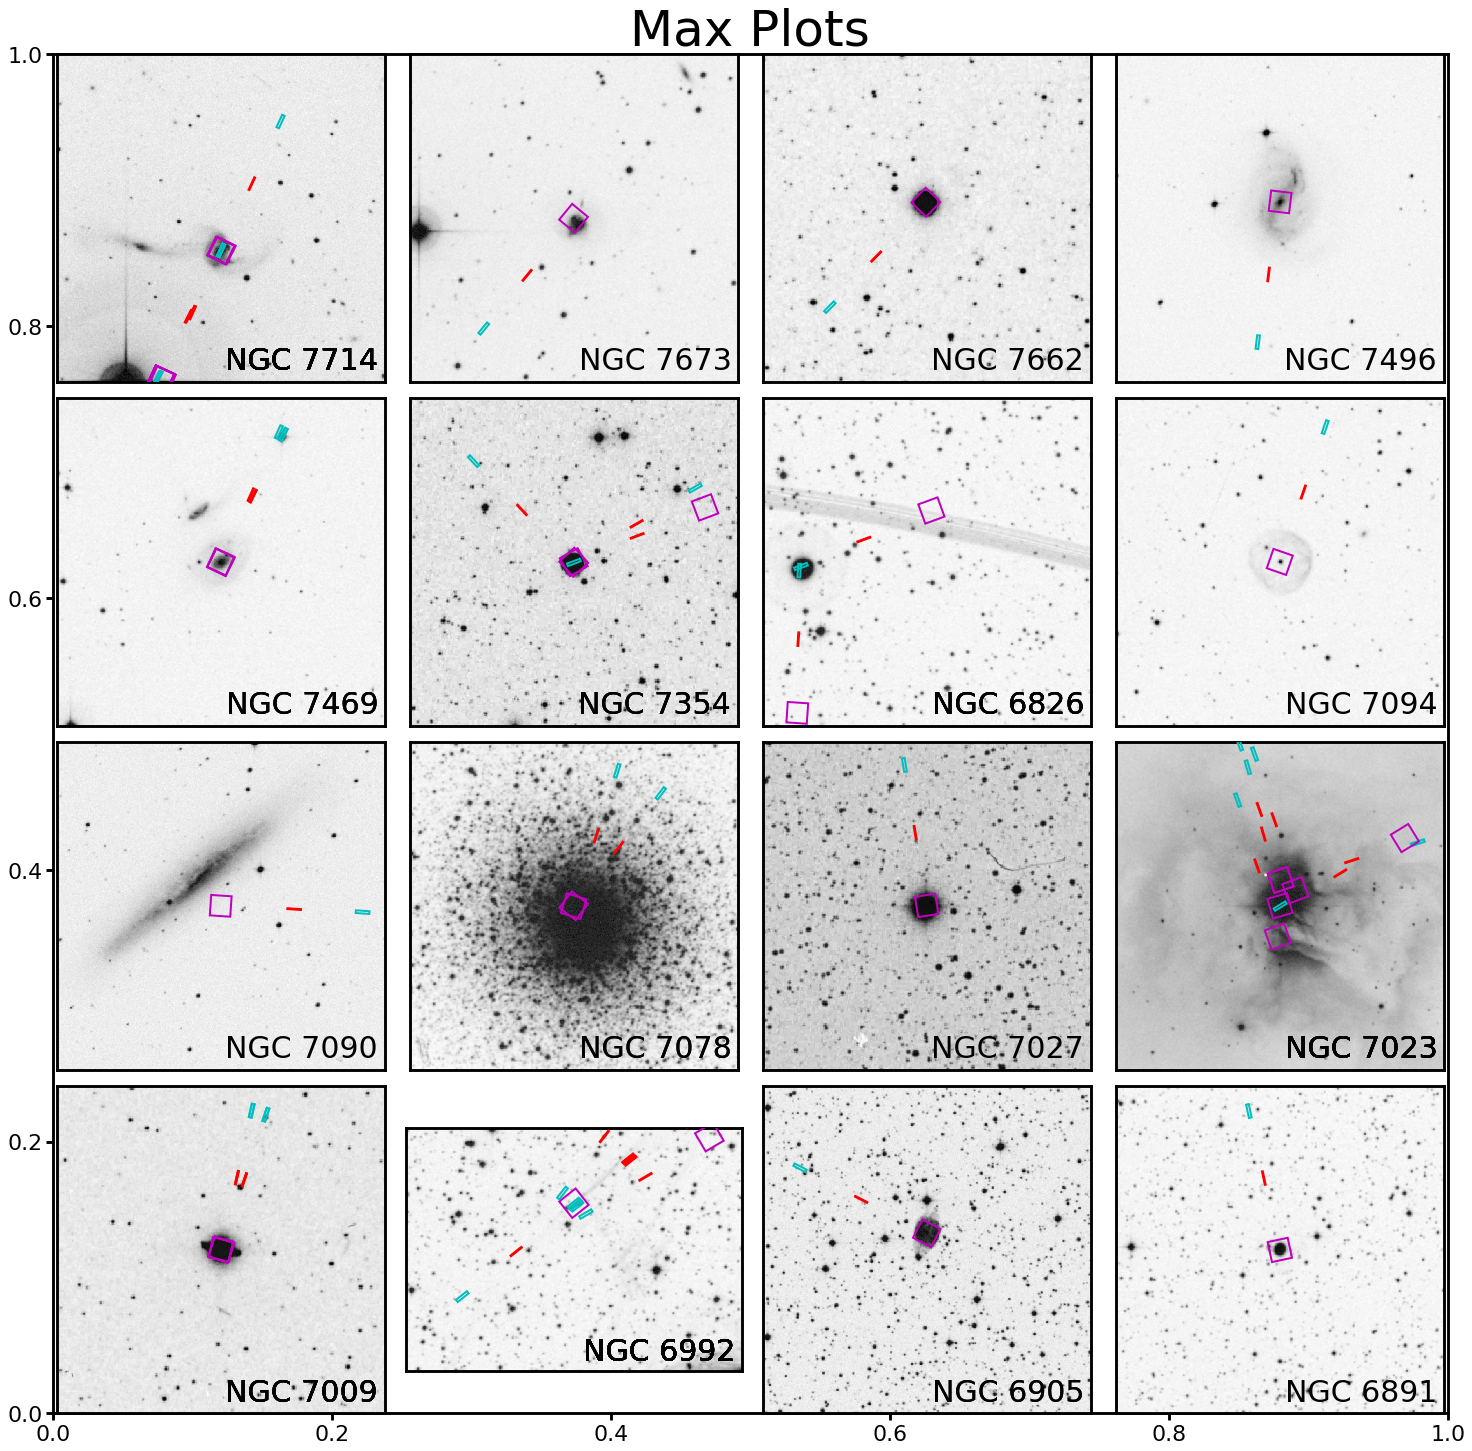

In [84]:
set_rcparams_prop(amp=1.15)

rr=1
aa=6
wrs=np.array([1.8, 0.2, 1.2, 0.05])
hrs=np.array([1])
fig = plt.figure(figsize=(20, 30))
fig = plt.figure(figsize=(25, 25))
plt.title("Max Plots",fontdict={'fontsize': 50})
ncol=4
nrow=4
gs1 = gridspec.GridSpec(nrow, ncol, figure=fig, 
#                         width_ratios=wrs, height_ratios=hrs,
                        hspace=0.05, wspace=0.05
                       )
pidxs=np.arange(ncol*nrow)
axs=[]
for i in range(len(pidxs)):
    ax=fig.add_subplot(gs1[i // ncol, i%ncol])
    axs.append(ax)


fidx=[1,1,1,1,
      1,0,0,0,
      0,0,0,0,
      0,0,0,0,
      0,0,0
     ]

# fidx=[1,0,0,0,0,
#       0,0,1,0,0,
#       0,0,0,0,0,
#       0,0,0,0
#      ]

# fidx=[1,0,0,0,0,
#       0,0,1,0,0,
#       1,0,0,1,0,
#       0,0,0,0
#      ]                 #Working for RED

# fidx=[1,1,1,1,1,
#       1,1,1,1,1,
#       1,1,1,1,1,
#       1,1,1,1
#      ]

# cut_widths=np.array([
#     350,300,400,400,
#     400,400,1400,1600,
#     600,1600,300,250,
#     250,250,500,400,
# ])/3600*2           # Working for RED

cut_widths=np.array([
    240,240,240,240,
    240,240,240,240,
    240,240,240,240,
    240,240,240,240,
])/3600*2 
print(cut_widths[1])


raoffs=np.array(
    [0,   0,   0, 0,
     0, 0,   5, 0,
     0,   0,   0, 0,
     0,   0,   0, 0,
    ]
)

decoffs=np.array(
    [0.1, 0, -0.05, -0.05,
     0, 0,    0,     0,
     0,   0,     0,    0,
     0,    0,-0.05,    0,
    ]
)

minsep=0.5
file_sc=SkyCoord(fdf.ra, fdf.dec, frame='icrs', unit='deg')    
for i in range(len(objnames)):
    
# for i in range(8):

#     if i == 3 or i == 4 or i == 6 or i == 8 or i == 12 or i == 13:
#         continue
#     if i == 0 or i == 6:
#         continue
#     if i == 6 :
# # #     or i == 6:
#         continue
# NGC6997
    print('iiiii ',i)
    ax=axs[i]
    objname=objnames[i]
    print('galname:', objname)
    sdf=df.loc[df['objname']==objname,:]
    sdf.index=np.arange(len(sdf))
    ra0, dec0=sdf.loc[0,'ra'], sdf.loc[0,'dec']
#     print(ra0, dec0)
    c = SkyCoord(ra0, dec0, frame='icrs', unit='deg')
    cond=np.array(file_sc.separation(c))<minsep
    print('ra0, dec0', ra0, '  ',dec0)
    print('sum cond', np.sum(cond))
    match_df=fdf[cond]
    match_df.index=np.arange(np.sum(cond))
    print('number of matched DF',len(match_df))
    # print(match_df.loc[fidx[i],'file_path'][0:44] + match_df.loc[fidx[i],'file_path'][60:])
    fits_file=match_df.loc[fidx[i],'file_path']
#     print(match_df.loc[fidx[i],:])
#     fits_file=match_df.loc[fidx[i],'file_path'][0:44] + match_df.loc[fidx[i],'file_path'][60:] #61forblue,60forred
    print('i and fidx',i, fidx[i])
    print(fits_file)
    hdu=fits.open(os.path.normpath(fits_file))
    hdr=hdu[0].header
    oiwcs=astropy.wcs.WCS(header=hdr) 
#     print(fits_file)
    
    cmap=cm.gray_r
    origin='lower'

    oim=hdu[0].data

    ra00, dec00=sdf.loc[0,'ra'], sdf.loc[0,'dec']
    ra0, dec0=sdf.loc[0,'ra']+cut_widths[i]*raoffs[i], sdf.loc[0,'dec']+cut_widths[i]*decoffs[i]
#     print(ra0, dec0)
    cc00 = SkyCoord(ra00, dec00, frame='icrs', unit='deg')
    cc = SkyCoord(ra0, dec0, frame='icrs', unit='deg')
    
    print(oiwcs)
    print('cc')
    print(cc)
    print('cc00')
    print(cc00)
    
    img_cutout_obj=Cutout2D(oim, cc, 
                       u.Quantity(cut_widths[i], unit='deg'),
                       wcs=oiwcs,
                    mode='trim',
#                     mode='partial',
                   )
    
    im=img_cutout_obj.data
    iwcs=img_cutout_obj.wcs

    
    img=ax.matshow(im, 
               cmap=cmap, 
               origin=origin, interpolation='none', 
#                zorder=1,
#               alpha=alpha, zorder=zorder, aspect=aspect, 
#                norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
                  )
#     print(objname)
    print('npt',len(sdf))
    
    for j in range(len(sdf)):
        jra, jdec=sdf.loc[j,'ra'], sdf.loc[j,'dec']        
        c_obj=SkyCoord(jra, jdec, 
                                          unit='deg',
                                          frame='icrs')
        if sdf.loc[j,'aperture']=='MDRS':
            sep=u.Quantity(-90.18-118.07, unit='arcsec')
            c_obj=c_obj.directional_offset_by(u.deg*(sdf.loc[j,'pa']+180), sep)
            print('MDRS!!!')

        sep=u.Quantity(90.18+118.07, unit='arcsec')
        m_obj=c_obj.directional_offset_by(u.deg*(sdf.loc[j,'pa']+180), sep)
        sep=u.Quantity(-10.27+118.07, unit='arcsec')
        h_obj=c_obj.directional_offset_by(u.deg*(sdf.loc[j,'pa']+180), sep)
         
        objs=[c_obj, m_obj, h_obj]
        xws=[30,4,1.25]
        yws=[30,20,20]
        clrs=['m','c','r']
        
        for k in range(3):
            pcent_x, pcent_y=iwcs.world_to_pixel(objs[k])
            psm=iwcs.pixel_scale_matrix
            pscale=(psm[0,0]**2+psm[0,1]**2)**0.5
    #         print('pscale',pscale)
            pxwidth=xws[k]/3600/pscale
            pywidth=yws[k]/3600/pscale
#             edgecolor='m'
            edgecolor=clrs[k]
    #         edgecolor='k'
            sqlw=2


            rot_ang=0
            rot_ang=sdf.loc[j,'pa']
            recx, recy=rec_rotate(pcent_x, pcent_y, pxwidth, pywidth, rot_ang)
            rec=matplotlib.patches.Rectangle((recx, recy,), pxwidth, pywidth, alpha=1, 
                                             angle=rot_ang,
                                             zorder=20,
        #     rec=matplotlib.patches.Rectangle((pcent_x-pxwidth/2,pcent_y-pywidth/2), pxwidth, pywidth, alpha=1, 
        #                                      angle=(-180),
        #                                   facecolor='w', fill=True)
                                    linewidth=sqlw, edgecolor=edgecolor, linestyle='-', fill=False)
            #                                               linewidth=1.5, edgecolor='w', linestyle=esty[k-1], fill=False)
            art=ax.add_artist(rec)
        ax.text(0.98,0.02,objname,
                horizontalalignment='right',
                verticalalignment='bottom',
                transform=ax.transAxes,
                size=30
               )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        
#         pcent_x, pcent_y=iwcs.world_to_pixel(m_obj)
#         psm=iwcs.pixel_scale_matrix
#         pscale=(psm[0,0]**2+psm[0,1]**2)**0.5
# #         print('pscale',pscale)
#         pxwidth=4/3600/pscale
#         pywidth=20/3600/pscale
#         edgecolor='c'
# #         edgecolor='k'
#         sqlw=3

        
#         rot_ang=0
#         rot_ang=sdf.loc[j,'pa']
#         recx, recy=rec_rotate(pcent_x, pcent_y, pxwidth, pywidth, rot_ang)
#         rec=matplotlib.patches.Rectangle((recx, recy,), pxwidth, pywidth, alpha=1, 
#                                          angle=rot_ang,
#                                          zorder=20,
#     #     rec=matplotlib.patches.Rectangle((pcent_x-pxwidth/2,pcent_y-pywidth/2), pxwidth, pywidth, alpha=1, 
#     #                                      angle=(-180),
#     #                                   facecolor='w', fill=True)
#                                 linewidth=sqlw, edgecolor=edgecolor, linestyle='-', fill=False)
#         #                                               linewidth=1.5, edgecolor='w', linestyle=esty[k-1], fill=False)
#         art=ax.add_artist(rec)
    
csp=0.0
fig.subplots_adjust(wspace=csp, hspace=csp)

# aa=cc.separation(c)
# np.array(Angle(aa, unit=u.deg))<0.5
match_df

fname='adap_newtarget_pointings2022.pdf'
#fig.savefig(fname,dpi=256, bbox_inches='tight')

In [89]:
# 67.2 arcsec/mm * (0.015 mm) = arcsec
67.2*0.015

1.008

In [79]:

# Number of WCS axes: 2
# CTYPE : 'RA---TAN'  'DEC--TAN'  
# CRVAL : 300.27916666666664  50.111111111111114  
# CRPIX : -8456.635092702712  -918.738345382395  
# PC1_1 PC1_2  : 0.015029457310875141  -2.763890417656235e-05  
# PC2_1 PC2_2  : 2.943457860649147e-05  0.014999988475789839  
# CDELT : -0.018648148399623195  0.018648148399623195  
# NAXIS : 1587  1590
# cc
# <SkyCoord (ICRS): (ra, dec) in deg
#     (296.12062467, 50.525056)>
# cc00
# <SkyCoord (ICRS): (ra, dec) in deg
#     (295.453958, 50.525056)>

# 300.2791666
print(-0.018648*8456.63)

-157.69923624


In [ ]:
fdf.ra


In [ ]:
['obsID',
 'obs_collection',
 'dataproduct_type',
 'obs_id',
 'description',
 'type',
 'dataURI',
 'productType',
 'productGroupDescription',
 'productSubGroupDescription',
 'productDocumentationURL',
 'project',
 'prvversion',
 'proposal_id',
 'productFilename',
 'size',
 'parent_obsid',
 'dataRights',
 'calib_level']

In [ ]:
# print(obs_table)
# np.sum(obs_table['obs_collection']=='FUSE')
obs_table
# products = Observations.get_product_list(obs_table[0])
# products
data_url=obs_table[0]['dataURL']
cdir='./galex_fits/'
fname='_'.join([objname,'galex','fuv'])+'.fits.gz'
print(data_url)
print(cdir+fname)
# urllib.request.urlretrieve(data_url, cdir+fname)

In [ ]:
obs_table

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy
from matplotlib import ticker
# import dotifs_util as util
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoLocator, FixedLocator,
                               AutoMinorLocator)
# import util
from scipy.optimize import curve_fit


import numpy as np
from scipy import constants
from scipy.interpolate import interp1d
import time
from os import path, getcwd
#from os import getcwd
import inspect
from math import pi
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel
from scipy.signal import convolve as scipyconvolve
import glob
stof=2*(2*np.log(2))**0.5

from astropy.io import fits

import math
import healpy as hp
import pylab

from astropy import units as u
from astropy.coordinates import SkyCoord


# from __future__ import print_function
from astropy.coordinates import SkyCoord
from dustmaps.sfd import SFDQuery

import csv
import numpy as np
import extinction
import requests
import pandas as pd
from PIL import Image, ImageDraw, ImageFilter
#import time
import os
from astroquery.simbad import Simbad
from astropy import units as u

import warnings
warnings.filterwarnings("ignore")


In [ ]:
def set_rcparams_prop(amp=1, fs=22):
#     fs=18
    tickmajorwidth=2.5*amp
    tickminorwidth=2.5*amp
    axeslw=2.5*amp
    tmjs=6*amp
    tmns=tmjs/3.5*2*amp
    plt.rcParams['axes.titlesize']=fs
    plt.rcParams['axes.labelsize']=fs
    plt.rcParams['xtick.labelsize']=fs
    plt.rcParams['ytick.labelsize']=fs
    plt.rcParams['axes.linewidth'] = axeslw
    plt.rcParams['xtick.major.width'] = tickmajorwidth
    plt.rcParams['ytick.major.width'] = tickmajorwidth
    plt.rcParams['xtick.minor.width'] = tickminorwidth
    plt.rcParams['ytick.minor.width'] = tickminorwidth
    plt.rcParams['xtick.major.size'] = tmjs
    plt.rcParams['ytick.major.size'] = tmjs
    plt.rcParams['xtick.minor.size'] = tmns
    plt.rcParams['ytick.minor.size'] = tmns

In [ ]:
# df_sim = Simbad.query_object(galaxies['Object Name'][i])
df_sim = Simbad.query_object('NGC 4631')

In [ ]:
df_sim.columns
# df_sim.loc['RA',:]
print(df_sim['RA'], df_sim['DEC'])
coords = SkyCoord(df_sim['RA'], df_sim['DEC'], frame='icrs', unit=(u.hourangle, u.deg))
# coords = SkyCoord(df_sim['RA'], df_sim['DEC'], frame='icrs')
coords

In [ ]:
gal_list=[
    "NGC 4631",
    "NGC 3003",
    "NGC 891",
    "NGC 5746",
    "NGC 1353",
    "NGC 253",
    "NGC 3692",
    "NGC 3044",
    "NGC 5775",
    "NGC 4666",
    "NGC 625",
    "NGC 7064",
    "NGC 1406",
    "NGC 1448",
    "NGC 660",
    "IC 5052",
    "M82",
    "NGC 7582",
]

In [ ]:
df_res=Simbad.query_objects(gal_list)
coords = SkyCoord(df_res['RA'], df_res['DEC'], frame='icrs', unit=(u.hourangle, u.deg))
coords

gdf=pd.DataFrame({
    'name':df_res['MAIN_ID'],   
    'ra':coords.ra.degree,
    'dec':coords.dec.degree,
    'l':coords.galactic.l.degree,
    'b':coords.galactic.b.degree,
})
gdf



In [ ]:
def under_sample(arr):
    iarr=arr[[np.arange(len(arr)//4)*4]]
    iarr=iarr+arr[[np.arange(len(arr)//4)*4+1]]
    iarr=iarr+arr[[np.arange(len(arr)//4)*4+2]]
    iarr=iarr+arr[[np.arange(len(arr)//4)*4+3]]
    return iarr/4

def under_sample(arr):
    val0=arr[[np.arange(len(arr)//4)*4]]
    val1=arr[[np.arange(len(arr)//4)*4+1]]
    val2=arr[[np.arange(len(arr)//4)*4+2]]
    val3=arr[[np.arange(len(arr)//4)*4+3]]
    tval=val0+val1+val2+val3
    non0=(val0>0)*1+(val1>0)*1+(val2>0)*1+(val3>0)*1
    tval=tval/non0
    tval[non0==0]=0
    return tval


def mag2flam(mag, zero_pt=21.1, ABwave=None):
    if np.any(ABwave != None):
        return 10.**(-0.4*(mag+2.406+5*np.log10(ABwave)))
    return 10.**(-0.4*(mag+zero_pt))

In [ ]:
lon_plot=np.radians(360-gdf['l'])
lat_plot=np.radians((gdf['b']))
lon_plot[lon_plot>np.pi]=lon_plot[lon_plot>np.pi]-2*np.pi

In [ ]:
fig=plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection="mollweide")

markersize=1

# rplon=np.radians(lon_plot)
# rplat=np.radians(lat_plot)
# rplon[rplon>np.pi]=rplon[rplon>np.pi]-2*np.pi

ax.scatter(lon_plot, lat_plot,
# ax.scatter(plon, plat,
#             -aspera_targets_ra.wrap_at(180 * u.deg).radian,
#             aspera_targets_dec.radian,
            marker="o",
            s=markersize*20,
            c="blue",
#             label='Aspera Science Targets'
            )

# odf=pd.DataFrame({
#     'gal_lon':plon,
#     'gal_lat':plat,}
# )
# print(len(odf))
# odf.to_csv('nox_target_coord_galactic.csv')

In [ ]:
gdf